# Digital Tools for Finance - Project
**Research Question:**\
What is the effect of the Real U.S. GDP on different S&P500 sector indices' market capitalizations

**Authors:**\
Jonas Neller, 21-730-676\
Lorena Tassone, 18-700-237\
Naomi Huser, 17-056-201

### Reproducibility Remarks:
Unfortunately the creation of a docker container doesn't work as planned. Hence the usage of the docker image is not possible.
main.ipynb has to be run from a jupyter notebook and dependencies have to be installed manually.
To be able to launch the application, the package "voila" must be installed manually (otherwise docker would have handled this). Run "pip install voila" or "conda install voila".

There is an interactive plot at the end of the code. Unfortunately, this interactivity only works within the notebook and not in the application.
Further, this interactive dropdown menu only works as long as the application is not running.
To run the server application, the last code snippet containing the command "!voila main.ipynb" must be uncommented and run.

## Inputs
If you want to use your own local data, create and input your environmental variable leading to the data and set 'envvar'=1. Otherwise set 'envvar'=0 and the dataset in the github repository will be used (suggested method).


In [1]:
### Input (default) ###

# envvar = 1: if want to use own ENVIRONMENTAL VARIABLE (Attention: need to redefine env_var)
# envvar = 0: if want to use data in github repository
envvar = 0
env_var = "RESEARCH_DATA_PATH"


## Data Cleaning

In [2]:
# libraries
import numpy as np
import pandas as pd
import os
from functools import reduce
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
import IPython.display
from IPython.display import display, clear_output


import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../data/interim')
from downstream import get_macro_data, get_SP500_mcap_data

import warnings
warnings.filterwarnings('ignore')

#!conda install voila 
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix  

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Enabling: voila
- Writing config: C:\Users\Lorena Tassone\anaconda3\etc\jupyter
    - Validating...
      voila 0.4.0 ok


In [3]:
# set variable according to environmental variable path or github path
if envvar == 1:
    path = os.environ.get(env_var)
else:
    path = os.path.join('..','data','processed')


In [4]:
# start and end date of macro factors data (quarterly, first day of month)
start_date_macro = "2007-01-01"
end_date_macro = "2021-01-01"

# start and end date of S&P500 mcap data (quarterly, last day of month)
start_date_sp500 = "2006-12-29"
end_date_sp500 = "2020-12-31"

In [5]:
# get mcap data
data_mcap = get_SP500_mcap_data(path) # later changed to mio.

# get macro data for each factor
data_gdp = get_macro_data(path,"Real_GDP", start_date_macro, end_date_macro) # in bio.
data_gdp = data_gdp[['Real_GDP']]
data_gdp['Real_GDP'] = data_gdp['Real_GDP'] * 1000 # now in mio
data_unempr = get_macro_data(path,'Unemployment_rate', start_date_macro, end_date_macro)
data_crudeprice = get_macro_data(path,'Crude_price', start_date_macro, end_date_macro)
data_feddebt = get_macro_data(path,'Federal_debt', start_date_macro, end_date_macro) # in mio.
data_feddebt = data_feddebt[['Federal_debt']]
data_fedrate = get_macro_data(path,'Federal_rate', start_date_macro, end_date_macro)

# merge factors by quarterly date
data_frames = [data_gdp, data_unempr, data_crudeprice, data_feddebt, data_fedrate]
data_factors_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date '], how='inner'), data_frames)
data_factors_merged.index = pd.to_datetime(data_factors_merged.index).date
n_factors = len(data_factors_merged.columns)
#data_factors_merged



In [6]:
# create subsectors
data_mcap.columns = data_mcap.loc['Sector',:]
sectors = data_mcap.loc['Sector',:].unique()
#print(sectors)

start = 0
end = 0

communication = data_mcap[['Communication Services']].tail(-3)
communication.index = pd.to_datetime(communication.index).date


# get index of start and end date (since .loc doesn't work)
for idx, date in enumerate(communication.index):
    if str(date) == start_date_sp500:
        start = idx
        #print(start)
    if str(date) == end_date_sp500:
        end = idx
        #print(end)
        
communication = communication.iloc[start:end+1,:]

consumerdisc = data_mcap[['Consumer Discretionary']].tail(-3)
consumerdisc.index = pd.to_datetime(consumerdisc.index).date
consumerdisc = consumerdisc.iloc[start:end+1,:]

consumerstap = data_mcap[['Consumer Staples']].tail(-3)
consumerstap.index = pd.to_datetime(consumerstap.index).date
consumerstap = consumerstap.iloc[start:end+1,:]

energy = data_mcap[['Energy']].tail(-3)
energy.index = pd.to_datetime(energy.index).date
energy = energy.iloc[start:end+1,:]

financials = data_mcap[['Financials']].tail(-3)
financials.index = pd.to_datetime(financials.index).date
financials = financials.iloc[start:end+1,:]

healthcare = data_mcap[['Health Care']].tail(-3)
healthcare.index = pd.to_datetime(healthcare.index).date
healthcare = healthcare.iloc[start:end+1,:]

industrials = data_mcap[['Industrials']].tail(-3)
industrials.index = pd.to_datetime(industrials.index).date
industrials = industrials.iloc[start:end+1,:]

informationtech = data_mcap[['Information Technology']].tail(-3)
informationtech.index = pd.to_datetime(informationtech.index).date
informationtech = informationtech.iloc[start:end+1,:]

materials = data_mcap[['Materials']].tail(-3)
materials.index = pd.to_datetime(materials.index).date
materials = materials.iloc[start:end+1,:]

realestate = data_mcap[['Real Estate']].tail(-3)
realestate.index = pd.to_datetime(realestate.index).date
realestate = realestate.iloc[start:end+1,:]

utilities = data_mcap[['Utilities']].tail(-3)
utilities.index = pd.to_datetime(utilities.index).date
utilities = utilities.iloc[start:end+1,:]

#utilities

In [7]:
# check if correct time series for macro factors and mcap data are selected
# otherwise we regress wrong values!
diff = communication.index - data_factors_merged.index
#print(diff)

if all(d.days > -5 for d in diff): # because measurement lag of ~3 days
    pass
else:
    sys.exit("Time series of macro factors and market cap do not coincide. Re-set start and end date!")



In [8]:
# checking timeframe length
#print(len(utilities.index))
#print(len(data_factors_merged))

In [9]:
# Manipulate data
#print(communication.shape)
communication = communication.dropna(axis=1) # Drop Companies with missing Market Cap Data
communication.columns = np.arange(len(communication.columns)) # reset column names
communication = communication.set_index(data_factors_merged.index) # set identical index as factor data
communication = communication/1000000 # mcap in millions
#print(communication.shape)

#print(consumerdisc.shape)
consumerdisc = consumerdisc.dropna(axis=1)
consumerdisc.columns = np.arange(len(consumerdisc.columns))
consumerdisc = consumerdisc.set_index(data_factors_merged.index)
consumerdisc = consumerdisc/1000000
#print(consumerdisc.shape)

#print(consumerstap.shape)
consumerstap = consumerstap.dropna(axis=1)
consumerstap.columns = np.arange(len(consumerstap.columns))
consumerstap = consumerstap.set_index(data_factors_merged.index)
consumerstap = consumerstap/1000000
#print(consumerstap.shape)

#print(energy.shape)
energy = energy.dropna(axis=1)
energy.columns = np.arange(len(energy.columns))
energy = energy.set_index(data_factors_merged.index)
energy = energy/1000000
#print(energy.shape)

#print(financials.shape)
financials = financials.dropna(axis=1)
financials.columns = np.arange(len(financials.columns))
financials = financials.set_index(data_factors_merged.index)
financials = financials/1000000
#print(financials.shape)

#print(healthcare.shape)
healthcare = healthcare.dropna(axis=1)
healthcare.columns = np.arange(len(healthcare.columns))
healthcare = healthcare.set_index(data_factors_merged.index)
healthcare = healthcare/1000000
#print(healthcare.shape)

#print(industrials.shape)
industrials = industrials.dropna(axis=1)
industrials.columns = np.arange(len(industrials.columns))
industrials = industrials.set_index(data_factors_merged.index)
industrials = industrials/1000000
#print(industrials.shape)

#print(informationtech.shape)
informationtech = informationtech.dropna(axis=1)
informationtech.columns = np.arange(len(informationtech.columns))
informationtech = informationtech.set_index(data_factors_merged.index)
informationtech = informationtech/1000000
#print(informationtech.shape)

#print(materials.shape)
materials = materials.dropna(axis=1)
materials.columns = np.arange(len(materials.columns))
materials = materials.set_index(data_factors_merged.index)
materials = materials/1000000
#print(materials.shape)

#print(realestate.shape)
realestate = realestate.dropna(axis=1)
realestate.columns = np.arange(len(realestate.columns))
realestate = realestate.set_index(data_factors_merged.index)
realestate = realestate/1000000
#print(realestate.shape)

#print(utilities.shape)
utilities = utilities.dropna(axis=1)
utilities.columns = np.arange(len(utilities.columns))
utilities = utilities.set_index(data_factors_merged.index)
utilities = utilities/1000000
#print(utilities.shape)

#communication

In [10]:
# take average mcap of each sector
data_factors_merged['mean_communication'] = communication.mean(axis=1)
data_factors_merged['mean_consumerdisc'] = consumerdisc.mean(axis=1)
data_factors_merged['mean_consumerstap'] = consumerstap.mean(axis=1)
data_factors_merged['mean_energy'] = energy.mean(axis=1)
data_factors_merged['mean_financials'] = financials.mean(axis=1)
data_factors_merged['mean_healthcare'] = healthcare.mean(axis=1)
data_factors_merged['mean_industrials'] = industrials.mean(axis=1)
data_factors_merged['mean_informationtech'] = informationtech.mean(axis=1)
data_factors_merged['mean_materials'] = materials.mean(axis=1)
data_factors_merged['mean_realestate'] = realestate.mean(axis=1)
data_factors_merged['mean_utilities'] = utilities.mean(axis=1)
data_factors_merged



,Real_GDP,Unemployment_rate,Crude_price,Federal_debt,Federal_rate,mean_communication,mean_consumerdisc,mean_consumerstap,mean_energy,mean_financials,mean_healthcare,mean_industrials,mean_informationtech,mean_materials,mean_realestate,mean_utilities
2007-01-01,15478956.0,4.6,54.780000,8849665,5.25,33566.840117,13976.755474,35114.892851,56310.751253,37776.126421,22132.352255,20349.909097,27144.892828,7853.160657,7264.136631,12883.127893
2007-04-01,15577779.0,4.5,63.974762,8867677,5.25,38302.249478,14503.530138,35212.858725,56438.893339,37015.969139,22413.011674,20382.270076,26421.560145,9070.796753,7742.640188,13911.226269
2007-07-01,15671605.0,4.7,74.046364,9007653,5.26,40624.381397,14662.968567,35588.168359,63317.858592,37527.513582,23103.166518,22189.265586,29391.742272,9796.573312,7148.311071,13639.476060
2007-10-01,15767146.0,4.7,85.926522,9229172,4.76,41623.296464,15037.524626,36732.824113,69278.232520,37453.745195,23375.133972,23358.406261,31306.212811,10566.540863,7338.628824,13798.571143
2008-01-01,15702906.0,5.0,92.982609,9437594,3.94,42096.907689,13285.795094,37801.508990,70566.237756,35004.099575,23350.162683,21849.902373,31631.543364,11177.673054,6721.944800,14455.568098
2008-04-01,15792773.0,5.0,112.336364,9492006,2.28,34650.526560,12018.632715,37128.022826,63541.830952,31040.045174,20347.138196,20693.358493,26651.761460,10757.432186,6579.862658,12858.594423
2008-07-01,15709562.0,5.8,133.958261,10024725,2.01,34676.869800,10568.747299,34485.101579,71802.664608,26359.737511,19646.907437,18369.901164,27269.837431,12293.842884,6345.412886,13743.757261
2008-10-01,15366607.0,6.5,76.283913,10699805,0.97,30124.157814,10736.198514,36335.700442,56421.450117,29074.541413,19459.001754,16690.777128,24108.561465,8464.278004,6663.310598,11613.945559
2009-01-01,15187475.0,7.8,41.630909,11126941,0.15,25669.455070,8256.185435,31451.094681,47308.732096,19784.217875,16791.544394,12571.210003,17901.993943,6054.703379,4424.134370,10315.682971
2009-04-01,15161772.0,9.0,49.905909,11545275,0.15,24115.505793,8070.414149,28089.438553,40462.398036,15437.949787,14908.839618,9794.054700,18646.924523,6193.916437,3399.104884,9275.650933


## Regression Output

In [11]:
# Regress mean market cap on GDP growth and controlling variables for all sectors
list_of_sectors = ["mean_communication","mean_consumerdisc","mean_consumerstap","mean_energy","mean_financials","mean_healthcare","mean_industrials","mean_informationtech","mean_materials","mean_realestate","mean_utilities"]

# regressions & output
models = []

for resp in list_of_sectors:
    formula = resp + " ~ Real_GDP + Unemployment_rate + Crude_price + Federal_debt + Federal_rate"
    res = smf.ols(formula, data = data_factors_merged).fit()
    models.append(res)

regoutputs = summary_col(models,stars=True)
print(regoutputs)

# latex table for paper
#regoutputs.as_latex()
    


                  mean_communication mean_consumerdisc mean_consumerstap  mean_energy  mean_financials mean_healthcare mean_industrials mean_informationtech mean_materials mean_realestate mean_utilities
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept         -426623.1332***    -101575.6982*     63161.7972*       140636.6070*  -61152.2646     -40738.0436     13095.0882       -100640.4068         -12439.7112    -29193.6376**   -24398.8807   
                  (131825.8134)      (53595.7324)      (33392.2623)      (75401.6600)  (49080.7712)    (35376.8140)    (23911.5315)     (139211.1836)        (14591.7968)   (12536.1712)    (16485.3283)  
Real_GDP          0.0260***          0.0049            -0.0031           -0.0054       0.0053          0.0025          -0.0006          0.0008               0.0007         0.0019**       

## Regression Plots

Communication Services


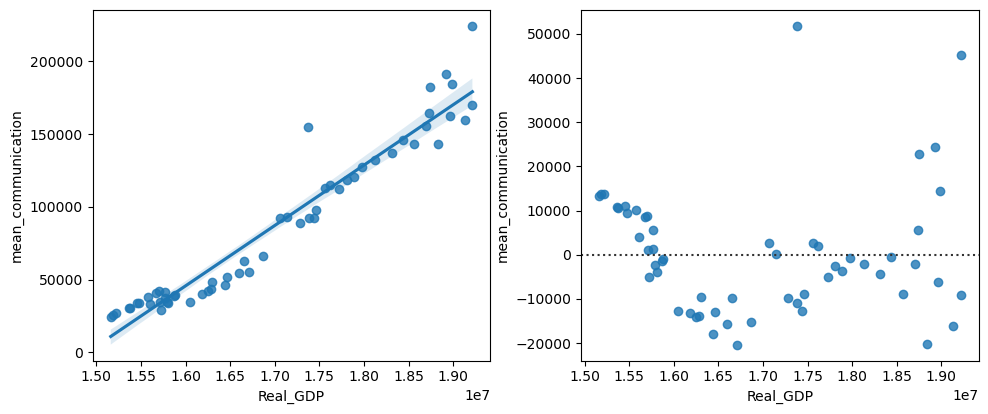

Consumer Discretionary


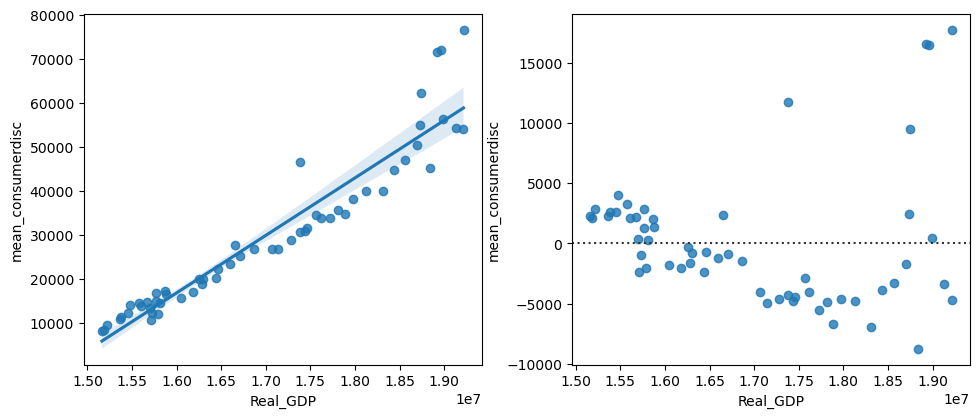

Consumer Staples


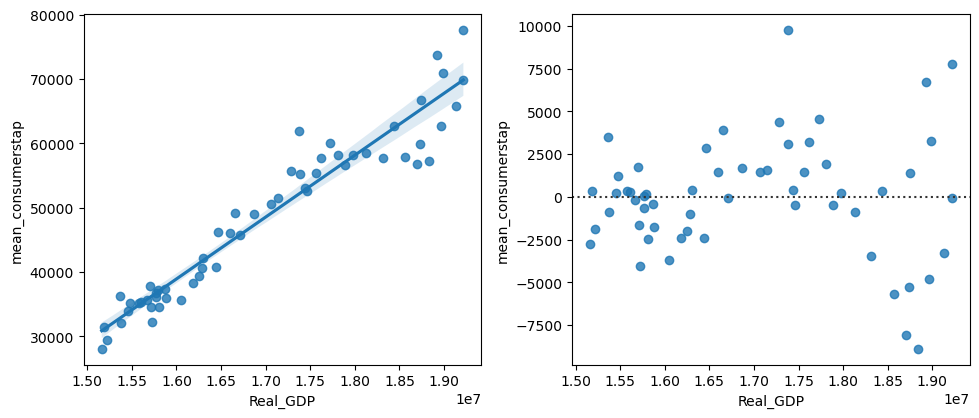

Energy


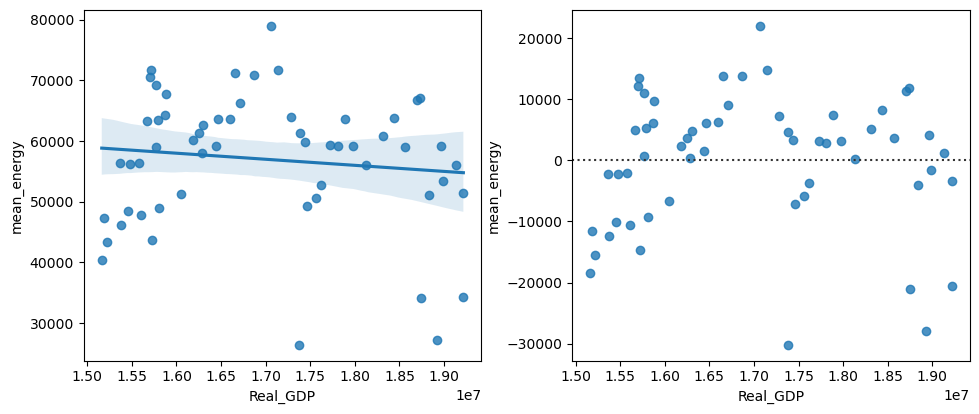

Financials


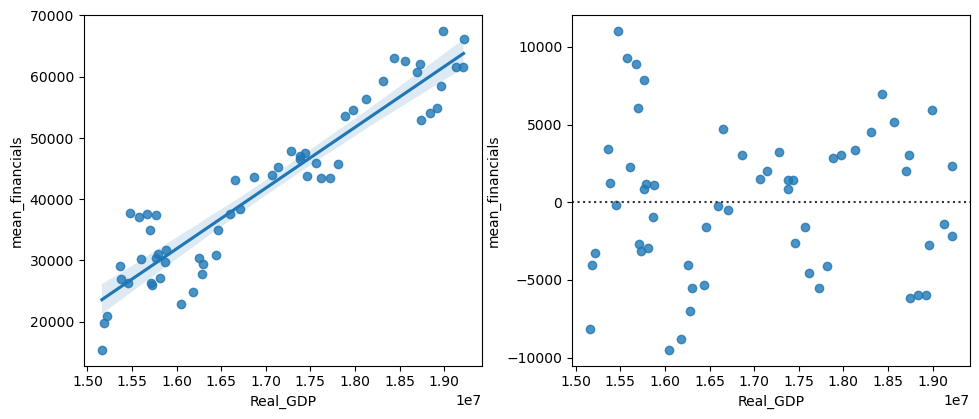

Health Care


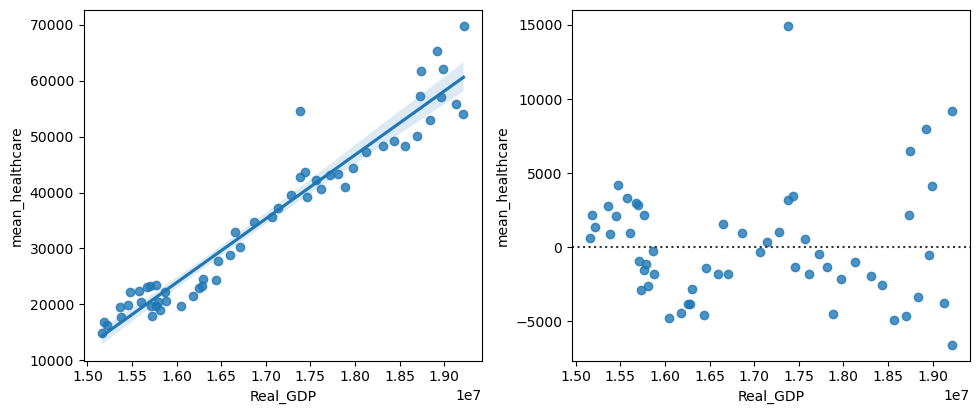

Industrials


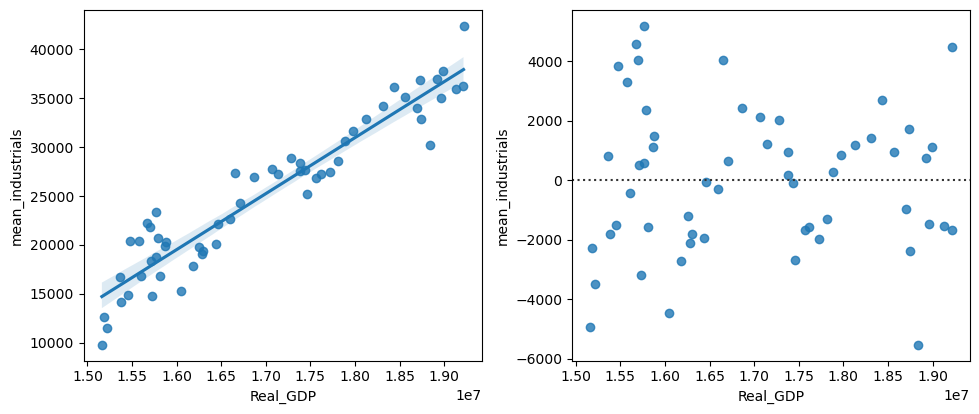

Information Technology


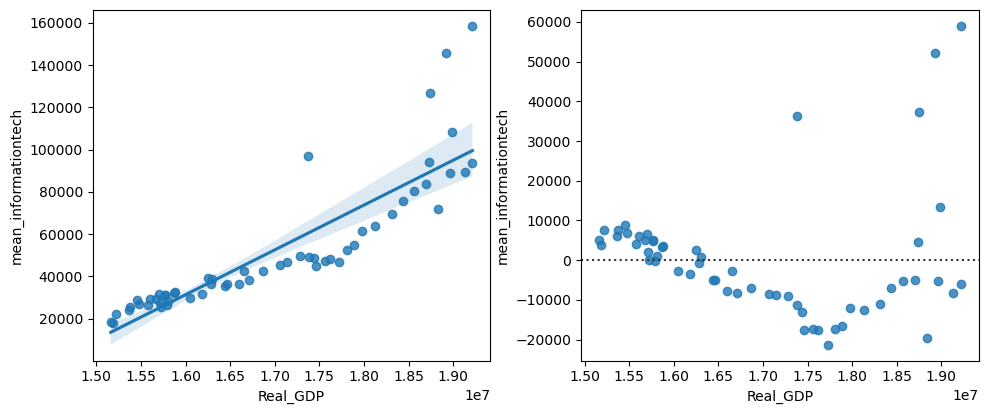

Materials


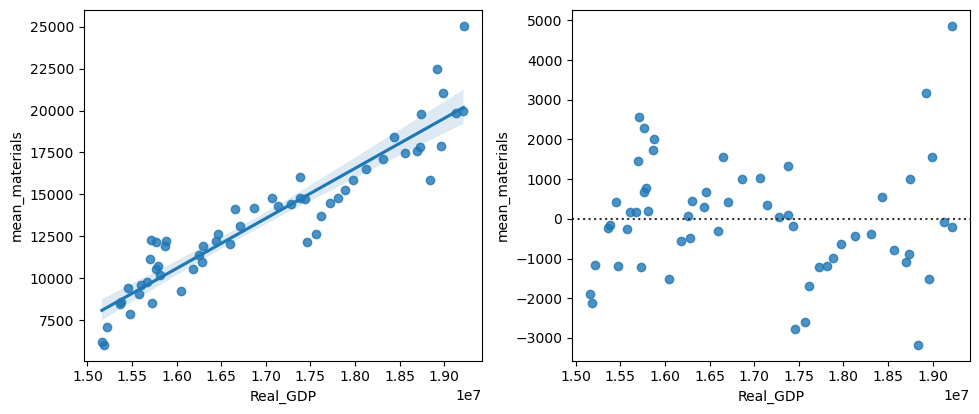

Real Estate


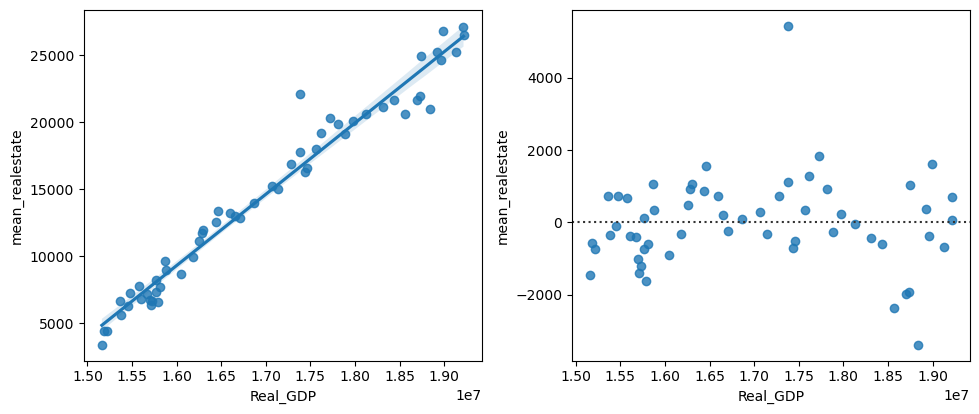

Utilities


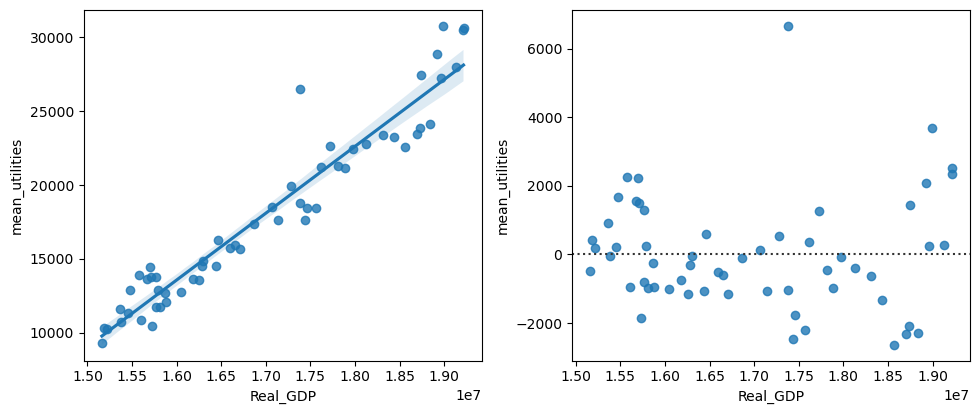

In [12]:
# regression plot

for s in range(len(sectors)):
    sector = data_factors_merged.columns[n_factors+s]
    print(sectors[s])

    fig, [ax0, ax1] = plt.subplots(1,2)
    fig.tight_layout()
    fig.set_size_inches([10,4])
    sns.regplot(data=data_factors_merged, x='Real_GDP', y=sector, ax=ax0)
    sns.residplot(data=data_factors_merged, x='Real_GDP', y=sector, ax=ax1)
    plt.show()


## Heatmap

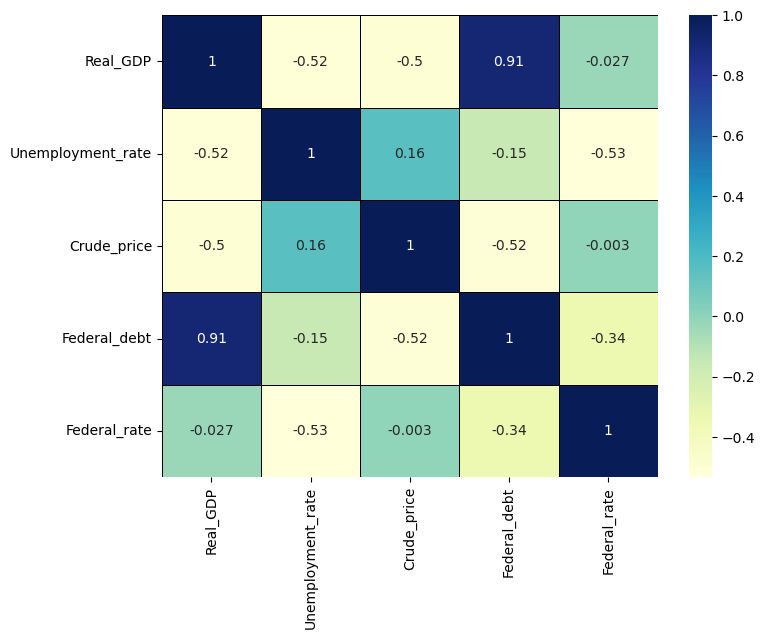

In [13]:
# heatmap

fig, ax = plt.subplots()
fig.set_size_inches([8,6])
sns.heatmap(data_factors_merged.iloc[:,:n_factors].corr(), annot=True, cmap="YlGnBu", linecolor="k", linewidth=0.5)
plt.show()


## Interactive Visualization

Interactivity only availabe in the Jupyter Notebook. Unfortunately it doesn't work in the application.

You must interrupt the application (the last code snippet) to be able to use the dropdown menu!

Dropdown(description='Sector', options=('Communication Services', 'Consumer Discretionary', 'Consumer Staples'…

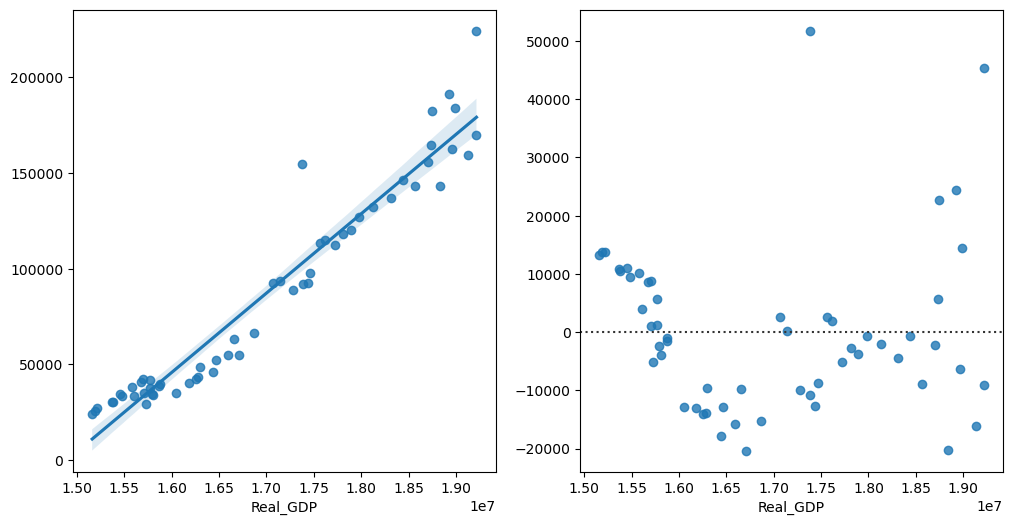

In [14]:
### First try

# dropdown selection for plot
data = {sectors[0]: data_factors_merged.iloc[:,5].values, 
        sectors[1]: data_factors_merged.iloc[:,6].values,
        sectors[2]: data_factors_merged.iloc[:,7].values, 
        sectors[3]: data_factors_merged.iloc[:,8].values,
        sectors[4]: data_factors_merged.iloc[:,9].values, 
        sectors[5]: data_factors_merged.iloc[:,10].values,
        sectors[6]: data_factors_merged.iloc[:,11].values, 
        sectors[7]: data_factors_merged.iloc[:,12].values,
        sectors[8]: data_factors_merged.iloc[:,13].values, 
        sectors[9]: data_factors_merged.iloc[:,14].values,
        sectors[10]: data_factors_merged.iloc[:,15].values}

default = sectors[0]

fig, [ax0, ax1] = plt.subplots(1,2)
fig.set_size_inches([12,6])
sns.regplot(x=data_factors_merged['Real_GDP'], y=data_factors_merged.iloc[:,5].values, ax=ax0)
sns.residplot(x=data_factors_merged['Real_GDP'], y=data_factors_merged.iloc[:,5].values, ax=ax1)

selection = widgets.Dropdown(
    options=data.keys(),
    value = default,
    description='Sector',
)
display(selection)
#selection

#output = widgets.Output()

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(selection)
        
        for item in data.items():
            if change['new'] == item[0]:
                sect = item[1]
            else:
                continue
        
        fig, [ax0, ax1] = plt.subplots(1,2)
        fig.set_size_inches([12,6])
        sns.regplot(x=data_factors_merged['Real_GDP'], y=sect, ax=ax0)
        sns.residplot(x=data_factors_merged['Real_GDP'], y=sect, ax=ax1)

selection.observe(on_change)

#new
#selection





### Application
Uncomment and run this following part to launch the application.

Stop the kernel if you want to use the interactive part above.

In [17]:
# !voila main.ipynb

^C
